In [36]:
!pip install piqa

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
^C
Traceback (most recent call last):
  File "/opt/conda/bin/pip", line 8, in <module>
    sys.exit(main())
  File "/opt/conda/lib/python3.8/site-packages/pip/_internal/cli/main.py", line 70, in main
    return command.main(cmd_args)
  File "/opt/conda/lib/python3.8/site-packages/pip/_internal/cli/base_command.py", line 101, in main
    return self._main(args)
  File "/opt/conda/lib/python3.8/site-packages/pip/_internal/cli/base_command.py", line 223, in _main
    self.handle_pip_version_check(options)
  File "/opt/conda/lib/python3.8/site-packages/pip/_internal/cli/req_command.py", line 190, in handle_pip_version_check
    pip_self_version_check(session, options)
  File "/opt/conda/lib/python3.8/site-packages/pip/_internal/self_outdated_check.py", line 227, in pip_self_version_check
    upgrade_prompt = _self_version_check_logic(
  File "/opt/conda/lib/python3.8/site-packages/pip/_internal/self_outdated_check.py"

In [32]:
!pwd

/workspace/MDUVSR-GoF (GroupOfFrames)/MDUVSR-Gof


In [2]:
import os
import torch
from PIL import Image, ImageOps
print(torch.__version__)
import piq
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import multiprocessing as mp


1.13.0a0+08820cb


In [2]:
"""### Preparing Data"""
import numpy as np
from torch.optim import Adam
import matplotlib.pyplot as plt
import argparse


In [3]:
import glob

path = '/workspace/vimeo_septuplet/sequences' #hr_path
res_path = r'/workspace/Vimeo90k/Zero_initialization_convlstm' #path_to_save_model
scale = 4
epochs = 50
name = 'test1'

In [4]:
import os
import torch
print(torch.__version__)
from patchify import patchify
from downsample import *
from tkinter import Tcl

1.13.0a0+08820cb


In [5]:
# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Load Data as Numpy Array 
#This function returns HR and LR frames. Data_size is the maximum frames to be taken as input
def read_data(path,scale,data_size):
    hr_data = []
    lr_data = []
    patch = []
    for dirname, _, filenames in os.walk(path):
        files = Tcl().call('lsort', '-dict', filenames)
        for filename in files:
            if len(hr_data)<data_size:
                f = os.path.join(dirname, filename)
    #             print(f)
                if filename.split('.')[-1] == 'png' or filename.split('.')[-1] == 'jpg':
                    img = Image.open(f)
                    img.load()
                    img_array = np.asarray(img)
                    img_array_lr = downsample(img_array, scale)
                    img_array_lr = np.swapaxes(img_array_lr,
                                            np.where(np.asarray(img_array_lr.shape) == min(img_array_lr.shape))[0][0], 0)
                    lr_data.append(img_array_lr)

    #                     patches = patchify(img_array_lr, (3, img_array_lr.shape[1] // 2, img_array_lr.shape[2] // 2),
    #                                        step=(img_array_lr.shape[1] // 8))
    #                     for i in range(patches.shape[0]):
    #                         for j in range(patches.shape[1]):
    #                             for k in range(patches.shape[2]):
    #                                 patch = patches[i, j, k]
    #                                 lr_data.append(patch)
    #                     #
                    img_array = np.swapaxes(img_array, np.where(np.asarray(img_array.shape) == min(img_array.shape))[0][0], 0)
                    hr_data.append(img_array)
    #                     patches = patchify(img_array, (3, img_array.shape[1] // 4, img_array.shape[2] // 4), step=(img_array.shape[1] // 8))
    #                     for i in range(patches.shape[0]):
    #                         for j in range(patches.shape[1]):
    #                             for k in range(patches.shape[2]):
    #                                 patch = patches[i, j, k]
    #                                 hr_data.append(patch)
    return hr_data, lr_data

In [6]:
all_hr_data, all_lr_data = read_data(path,4,50000)

In [7]:
len(all_hr_data)

50000

In [8]:
all_lr_data[0].shape,all_hr_data[0].shape

((3, 112, 64), (3, 448, 256))

In [9]:
# parameters to the function are lr_frames, corresponding hr frames, group_of_frames as input, max_len for hr frames
#(argument given in data_load function)
class CustomDataset(Dataset):
    def __init__(self, image_data, labels, gof, max_len):
        self.gof = gof
        self.max_len = max_len//self.gof
        self.image_data = image_data
        self.labels = labels
        print(max_len)

    def __len__(self):
#         print(len(self.image_data))
        return (self.max_len)

    def __getitem__(self, index):

        image = self.image_data[(index*self.gof):(index*self.gof) + self.gof]/255.0
        label = self.labels[(index*self.gof):(index*self.gof) + self.gof]/255.0
        return (
        torch.tensor(image, dtype=torch.float),
        torch.tensor(label, dtype=torch.float)
        )


In [10]:
def data_load(all_lr_data,all_hr_data, batch_size, workers, gof):

    # Train, Test, Validation splits
    train_data_hr = all_hr_data[:3*len(all_hr_data)//4]
    train_data_lr = all_lr_data[:3*len(all_lr_data)//4]
    print(f'len of train hr data ={len(train_data_hr)}')

    val_data_hr = all_hr_data[3*len(all_hr_data)//4:(3*len(all_hr_data)//4)+(len(all_hr_data)//4)]
    val_data_lr = all_lr_data[3*len(all_lr_data)//4:(3*len(all_lr_data)//4)+(len(all_lr_data)//4)]

    print(f'len of val hr data ={len(val_data_hr)}')
    # test_data_hr = all_hr_data[(len(all_hr_data)//3)+(len(all_hr_data)//4):(len(all_hr_data)//3)+(len(all_hr_data)//2)]
    # test_data_lr = all_lr_data[(len(all_lr_data)//3)+(len(all_lr_data)//4):(len(all_lr_data)//3)+(len(all_lr_data)//2)]

    print(f'hr {len(all_hr_data)}')
    print(f'lr {len(all_lr_data)}')

    train_data = CustomDataset(np.asarray(train_data_lr),np.asarray(train_data_hr),gof,len(np.asarray(train_data_lr)))
    val_data = CustomDataset(np.asarray(val_data_lr),np.asarray(val_data_hr),gof,len(np.asarray(val_data_lr)))
    # test_data = CustomDataset(np.asarray(test_data_lr),np.asarray(test_data_hr))
    print(f'dataset created')
    # Load Data as Numpy Array
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False, num_workers=workers,drop_last = True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=workers,drop_last = True)
    # test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=workers)
    
    print(f'train {len(train_data_hr)}')    
    print(f'val {len(val_data_hr)}')
    # print(f'test {len(test_data_hr)}')

    return train_loader, val_loader

In [11]:
train_loader, val_loader = data_load(all_lr_data,all_hr_data, batch_size=128, workers=2, gof=7)

len of train hr data =37500
len of val hr data =12500
hr 50000
lr 50000
37500
12500
dataset created
train 37500
val 12500


In [28]:
train_loader.dataset[0][0].shape, train_loader.dataset[0][1].shape,len(train_loader)

(torch.Size([7, 3, 112, 64]), torch.Size([7, 3, 448, 256]), 41)

In [13]:
gof = 7

In [14]:
train_loader.dataset[0][1][0]

tensor([[[0.5765, 0.6078, 0.6275,  ..., 0.6431, 0.6392, 0.6353],
         [0.5804, 0.6196, 0.6314,  ..., 0.6431, 0.6392, 0.6353],
         [0.6078, 0.6275, 0.6392,  ..., 0.6471, 0.6431, 0.6392],
         ...,
         [0.2314, 0.2275, 0.2275,  ..., 0.4941, 0.4549, 0.4314],
         [0.2314, 0.2275, 0.2235,  ..., 0.4549, 0.4824, 0.5137],
         [0.2275, 0.2275, 0.2235,  ..., 0.4235, 0.4157, 0.4000]],

        [[0.5098, 0.5216, 0.5373,  ..., 0.5490, 0.5412, 0.5373],
         [0.5176, 0.5333, 0.5412,  ..., 0.5490, 0.5412, 0.5373],
         [0.5216, 0.5373, 0.5451,  ..., 0.5529, 0.5451, 0.5373],
         ...,
         [0.1647, 0.1608, 0.1608,  ..., 0.5843, 0.6078, 0.6118],
         [0.1608, 0.1608, 0.1608,  ..., 0.6235, 0.6039, 0.5529],
         [0.1608, 0.1608, 0.1608,  ..., 0.5922, 0.5373, 0.4392]],

        [[0.5098, 0.5216, 0.5373,  ..., 0.6431, 0.6275, 0.6157],
         [0.5176, 0.5333, 0.5412,  ..., 0.6431, 0.6275, 0.6196],
         [0.5255, 0.5333, 0.5373,  ..., 0.6471, 0.6353, 0.

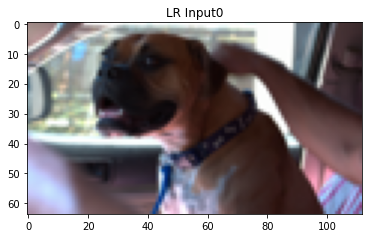

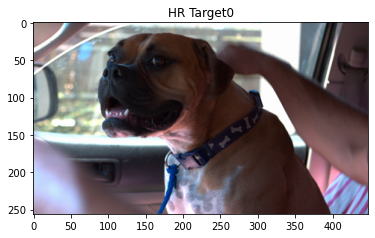

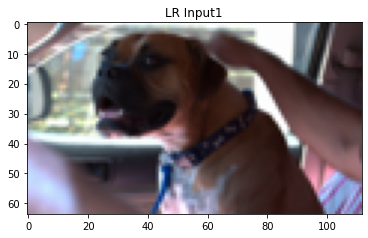

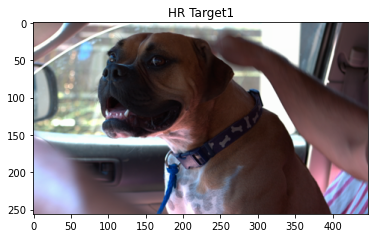

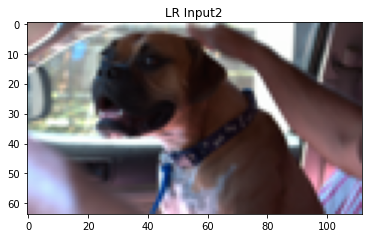

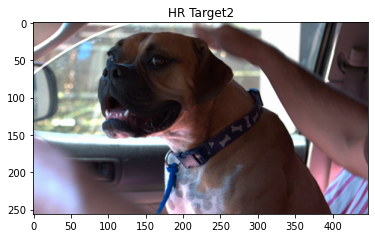

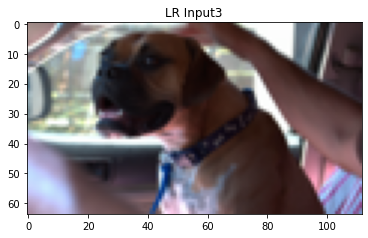

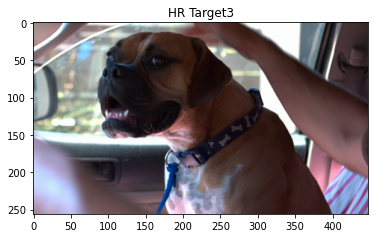

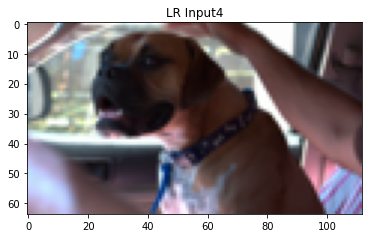

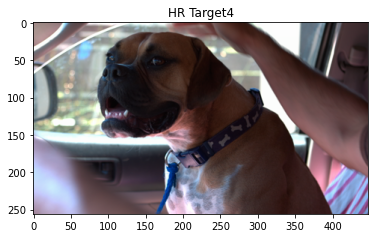

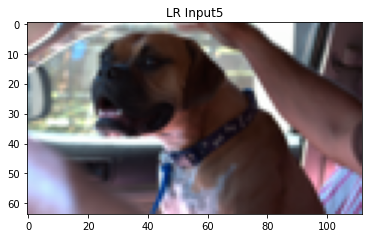

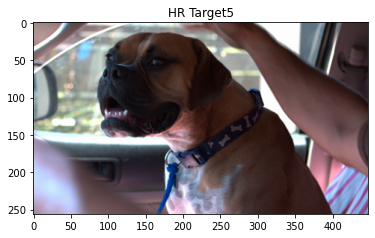

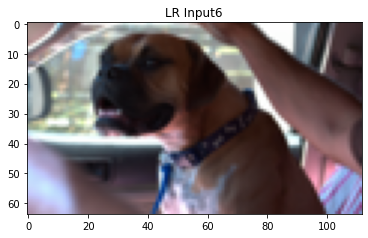

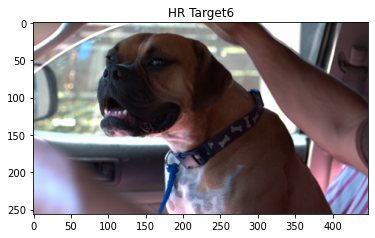

In [15]:
for i in range(gof):
    plt.figure()
    plt.title(f'LR Input{i}')
    plt.imshow((255.0*train_loader.dataset[0][0][i]).cpu().detach().numpy().T.astype(int))

    plt.figure()
    plt.title(f'HR Target{i}')
    plt.imshow((255.0*train_loader.dataset[0][1][i]).cpu().detach().numpy().T.astype(int))



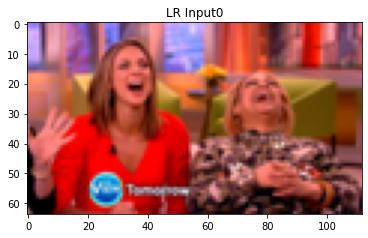

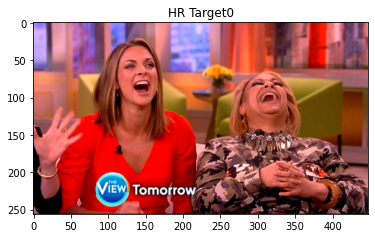

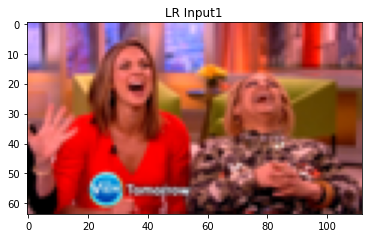

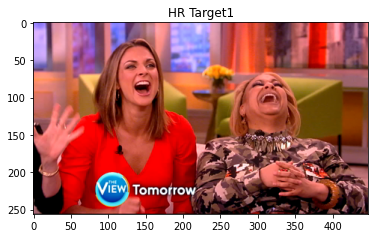

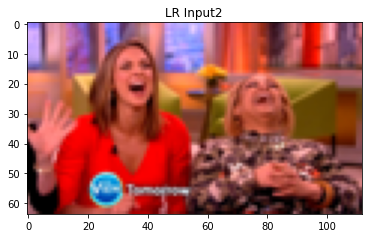

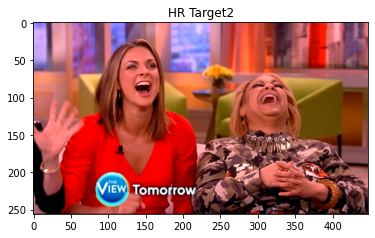

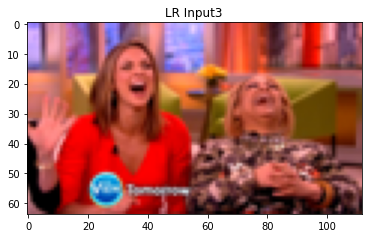

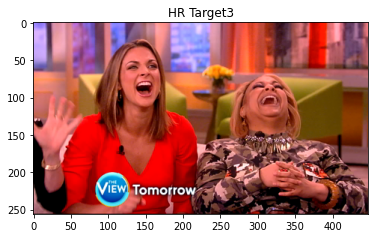

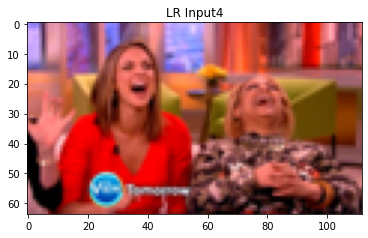

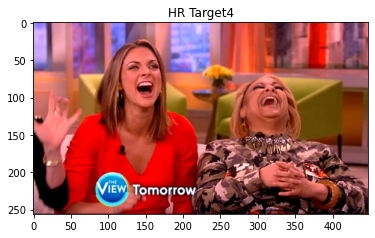

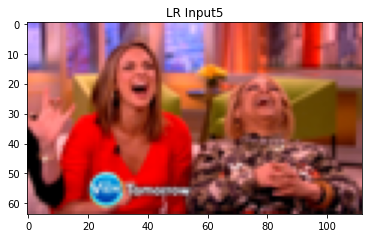

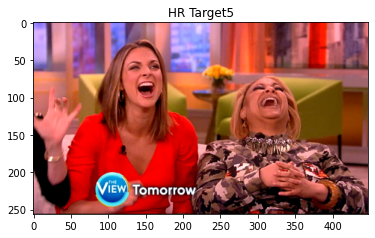

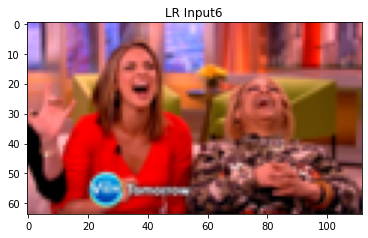

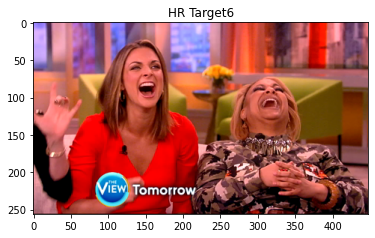

In [16]:

for i in range(gof):
    plt.figure()
    plt.title(f'LR Input{i}')
    plt.imshow((255.0*train_loader.dataset[1][0][i]).cpu().detach().numpy().T.astype(int))
    
    plt.figure()
    plt.title(f'HR Target{i}')
    plt.imshow((255.0*train_loader.dataset[1][1][i]).cpu().detach().numpy().T.astype(int))



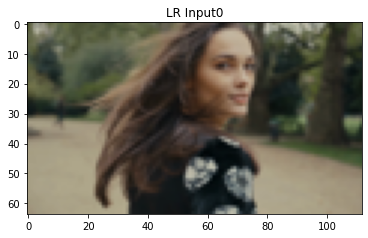

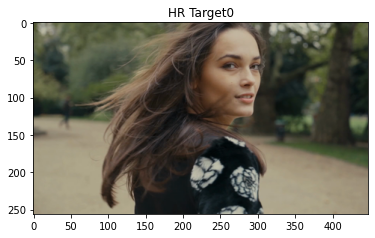

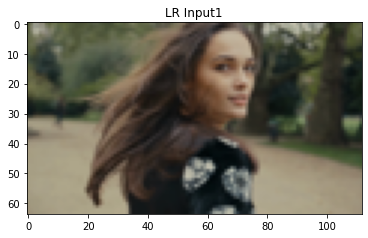

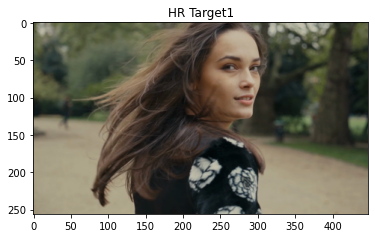

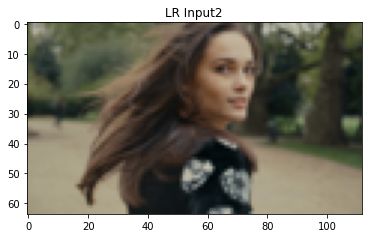

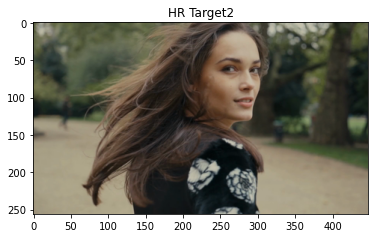

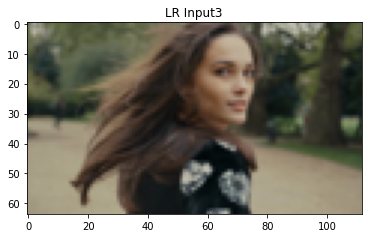

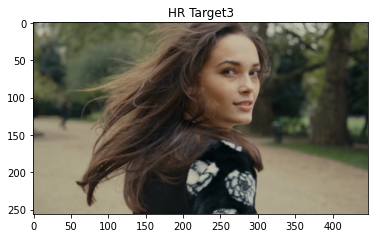

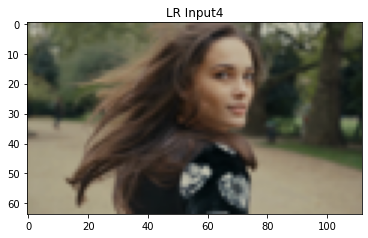

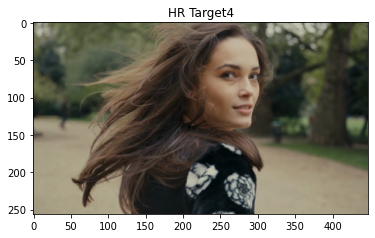

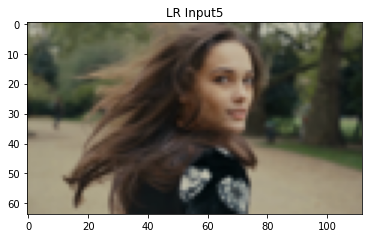

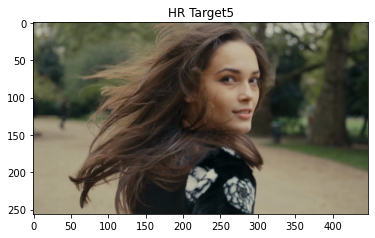

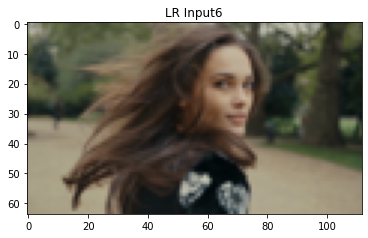

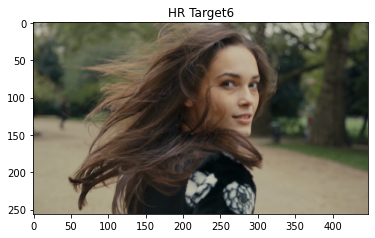

In [17]:

for i in range(gof):
    plt.figure()
    plt.title(f'LR Input{i}')
    plt.imshow((255.0*train_loader.dataset[2][0][i]).cpu().detach().numpy().T.astype(int))
    
    plt.figure()
    plt.title(f'HR Target{i}')
    plt.imshow((255.0*train_loader.dataset[2][1][i]).cpu().detach().numpy().T.astype(int))



In [18]:
import torchvision.ops
class DeformableConv2d(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 padding=1,
                 bias=False):
        super(DeformableConv2d, self).__init__()

        self.padding = padding

        self.offset_conv = nn.Conv2d(in_channels,
                                     2 * kernel_size * kernel_size,
                                     kernel_size=kernel_size,
                                     stride=stride,
                                     padding=self.padding,
                                     bias=True)

        nn.init.constant_(self.offset_conv.weight, 0.)
        nn.init.constant_(self.offset_conv.bias, 0.)

        self.modulator_conv = nn.Conv2d(in_channels,
                                        1 * kernel_size * kernel_size,
                                        kernel_size=kernel_size,
                                        stride=stride,
                                        padding=self.padding,
                                        bias=True)

        nn.init.constant_(self.modulator_conv.weight, 0.)
        nn.init.constant_(self.modulator_conv.bias, 0.)

        self.regular_conv = nn.Conv2d(in_channels=in_channels,
                                      out_channels=out_channels,
                                      kernel_size=kernel_size,
                                      stride=stride,
                                      padding=self.padding,
                                      bias=bias)

    def forward(self, x):
        h, w = x.shape[2:]
        max_offset = max(h, w) / 4.

        offset = self.offset_conv(x).clamp(-max_offset, max_offset)
        modulator = 2. * torch.sigmoid(self.modulator_conv(x))

        x = torchvision.ops.deform_conv2d(input=x,
                                          offset=offset,
                                          weight=self.regular_conv.weight,
                                          bias=self.regular_conv.bias,
                                          padding=self.padding,
                                          mask=modulator
                                          )
        return x

In [19]:
# Original ConvLSTM cell as proposed by Shi et al.
# device = torch.device('cpu')

# Original ConvLSTM cell as proposed by Shi et al.
class ConvLSTMCell(nn.Module):

    def __init__(self, in_channels, out_channels, 
    kernel_size, padding, activation, frame_size):

        super(ConvLSTMCell, self).__init__()  

        if activation == "tanh":
            self.activation = torch.tanh 
        elif activation == "relu":
            self.activation = torch.relu
        
        # Idea adapted from https://github.com/ndrplz/ConvLSTM_pytorch
        self.conv = nn.Conv2d(
            in_channels=in_channels + out_channels, 
            out_channels=4 * out_channels, 
            kernel_size=kernel_size, 
            padding=padding)           

        # Initialize weights for Hadamard Products
        self.W_ci = nn.Parameter(torch.Tensor(out_channels, *frame_size))
        self.W_co = nn.Parameter(torch.Tensor(out_channels, *frame_size))
        self.W_cf = nn.Parameter(torch.Tensor(out_channels, *frame_size))

    def forward(self, X, H_prev, C_prev):

        # Idea adapted from https://github.com/ndrplz/ConvLSTM_pytorch
        conv_output = self.conv(torch.cat([X, H_prev], dim=1))

        # Idea adapted from https://github.com/ndrplz/ConvLSTM_pytorch
        i_conv, f_conv, C_conv, o_conv = torch.chunk(conv_output, chunks=4, dim=1)

        input_gate = torch.sigmoid(i_conv + self.W_ci * C_prev )
        forget_gate = torch.sigmoid(f_conv + self.W_cf * C_prev )

        # Current Cell output
        C = forget_gate*C_prev + input_gate * self.activation(C_conv)

        output_gate = torch.sigmoid(o_conv + self.W_co * C )

        # Current Hidden State
        H = output_gate * self.activation(C)

        return H, C
    
class ConvLSTM(nn.Module):

    def __init__(self, in_channels, out_channels, 
    kernel_size, padding, activation, frame_size):

        super(ConvLSTM, self).__init__()

        self.out_channels = out_channels

        # We will unroll this over time steps
        self.convLSTMcell = ConvLSTMCell(in_channels, out_channels, 
        kernel_size, padding, activation, frame_size)

    def forward(self, X):

        # X is a frame sequence (batch_size, num_channels, seq_len, height, width)

        # Get the dimensions
        batch_size, _, seq_len, height, width = X.size()

        # Initialize output
        output = torch.zeros(batch_size, self.out_channels, seq_len, 
        height, width, device=device)
        
        # Initialize Hidden State
        H = torch.zeros(batch_size, self.out_channels, 
        height, width, device=device)

        # Initialize Cell Input
        C = torch.zeros(batch_size,self.out_channels, 
        height, width, device=device)

        # Unroll over time steps
        for time_step in range(seq_len):

            H, C = self.convLSTMcell(X[:,:,time_step], H, C)

            output[:,:,time_step] = H

        return output

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import gc

class mdpvsr_1defconv(nn.Module):

    def __init__(self, num_channels, num_kernels, kernel_size, padding,
                 scale, activation, frame_size, group_of_frames, num_layers, state=None):
        super(mdpvsr_1defconv, self).__init__()

        print(
            f'num_channels, num_kernels, group_of_frames, kernel_size, padding, scale, activation, frame_size {num_channels, num_kernels, group_of_frames, kernel_size, padding, scale, activation, frame_size}')
        self.group_of_frames = group_of_frames
        self.sequential = nn.Sequential()

        # Add First layer (Different in_channels than the rest)
        self.sequential.add_module(
            "convlstm1", ConvLSTM(
                in_channels=num_channels, out_channels=num_kernels,
                kernel_size=kernel_size, padding=padding, 
                activation=activation, frame_size=frame_size)
        )

        self.sequential.add_module(
            "batchnorm1", nn.BatchNorm3d(num_features=num_kernels)
        ) 

        # Add rest of the layers
        for l in range(2, num_layers+1):

            self.sequential.add_module(
                f"convlstm{l}", ConvLSTM(
                    in_channels=num_kernels, out_channels=num_kernels,
                    kernel_size=kernel_size, padding=padding, 
                    activation=activation, frame_size=frame_size)
                )
                
            self.sequential.add_module(
                f"batchnorm{l}", nn.BatchNorm3d(num_features=num_kernels)
                ) 

        self.deformable_convolution1 = DeformableConv2d(
            in_channels=group_of_frames * num_channels,
            out_channels=group_of_frames * num_channels,
            kernel_size=kernel_size[0],
            stride=1,
            padding=padding[0],
            bias=True)

        # Add rest of the layers
        
        self.conv1 = nn.Conv3d(
            in_channels=num_kernels, out_channels=num_channels, kernel_size=(1,1,1), padding=0)

        self.conv2 = nn.Conv3d(
            in_channels=num_channels, out_channels=num_channels * scale ** 2, kernel_size=(1,1,1), padding=0)

        self.up_block = nn.PixelShuffle(scale)

    def forward(self, X, state=None):
        # Forward propagation through all the layers
#         print(f'X.shape {X.shape}')
        lr = torch.transpose(X, 1, 2)
#         plt.figure(figsize=(15, 10))
#         plt.title('Input')
#         plt.imshow(lr.cpu()[-1].detach().numpy()[:,0,:,:].T.astype(int))
#         print(f'Input {lr.shape}')
        
        x = self.sequential(lr)
#         print(f'output from convlstm {x.size()}')
        x = self.conv1(x)
#         print(f'output from conv1 {x.size()}')
#         plt.figure(figsize=(15, 10))
#         plt.title('after convlstm')
#         plt.imshow(x.cpu()[-1].detach().numpy()[:,0,:,:].T.astype(int))
        y = list(torch.chunk(x, self.group_of_frames, dim=1))
        for i in range(len(y)):
            y[i] = torch.squeeze(y[i])
        x = torch.cat(y, dim=1)
#         plt.figure(figsize=(15, 10))
#         plt.title('before def conv')
#         plt.imshow(x.cpu()[-1][-1].detach().numpy().T.astype(int))
#         print(f'input to def conv shape {x.shape}')
        x = self.deformable_convolution1(x)
        x = torch.chunk(x, self.group_of_frames, dim=1)
#         print(f'After def conv {x[0].shape} and len x {len(x)}')
        x=torch.stack(x, dim=1)        
        x=torch.transpose(x, 1, 2)
#         print(f'After stack {x.shape}')
#         plt.figure(figsize=(15, 10))
#         plt.title('after def conv')
#         plt.imshow(x.cpu()[-1][-1].detach().numpy().T.astype(int))
        #         print(f'output from def conv {x}')
        #         print(f'torch.chunk(x,self.group_of_frames,dim=1) {torch.chunk(x,self.group_of_frames,dim=1)[0].shape}')
        #         x= torch.stack(torch.chunk(x,self.group_of_frames,dim=1),dim=1)
        #         print(f'torch.stack(x,dim=1) {x.shape}')
        #         x = torch.cat((x,lr),2)
        #         print(f'input to conv shape {x.shape}')
        x = self.conv2(x)
#         print(f'output from conv {x.shape}')
        x=torch.transpose(x, 1, 2)
#         plt.figure(figsize=(15, 10))
#         plt.title('before up conv')
#         plt.imshow(x.cpu()[-1][-1].detach().numpy().T.astype(int))
#         print(f'input to up_block {x.shape}')
        output = self.up_block(x)
#         print(f'output.shape {output.shape}')
#         plt.figure(figsize=(15, 10))
#         plt.title('After up conv')
#         plt.imshow(output.cpu()[-1].detach().numpy().T.astype(int))
        #         print(f'output {output}')

#         output = torch.clamp(output, 0, 255)
#         plt.figure(figsize=(15, 10))
#         plt.title('final output')
#         plt.imshow(output.cpu()[-1][0,:,:,:].detach().numpy().T.astype(int))
        #         print('output')
        #         print(output)

        return nn.Sigmoid()(output)

In [21]:
# num_channels, num_kernels, kernel_size, padding,
#                  scale, activation, frame_size
(train_loader.dataset[0][0].shape[0],train_loader.dataset[0][0].shape[1],train_loader.dataset[0][0].shape[2],train_loader.dataset[0][0].shape[3])

(7, 3, 112, 64)

In [22]:
print('Computation device: ', device)
model = mdpvsr_1defconv(num_channels=3,
num_kernels=64,
kernel_size=(3, 3),
padding=(1,1),
activation="relu",
scale=4,
group_of_frames = 7,
frame_size=(112,64),
num_layers=3).to(device)

Computation device:  cuda
num_channels, num_kernels, group_of_frames, kernel_size, padding, scale, activation, frame_size (3, 64, 7, (3, 3), (1, 1), 4, 'relu', (112, 64))


In [23]:
import os
import time
import torch
from PIL import Image, ImageOps
print(torch.__version__)
import piq
"""### ConvLSTM """
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torchsummary import summary

"""### Preparing Data"""
import numpy as np
from torch.optim import Adam
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import argparse

print(model)
print(summary(model, (7,3,112,64)))

1.13.0a0+08820cb
mdpvsr_1defconv(
  (sequential): Sequential(
    (convlstm1): ConvLSTM(
      (convLSTMcell): ConvLSTMCell(
        (conv): Conv2d(67, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (batchnorm1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (convlstm2): ConvLSTM(
      (convLSTMcell): ConvLSTMCell(
        (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (batchnorm2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (convlstm3): ConvLSTM(
      (convLSTMcell): ConvLSTMCell(
        (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (batchnorm3): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deformable_convolution1): DeformableConv2d(
    (offset_conv): Conv2d(21, 18, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (modulator_conv): Conv

In [108]:
# # Declaring the variable by using square kernels and equal stride
# c = nn.Conv3d(18, 35, 5, stride=1)

# # Describing the input and output variables
# input = torch.randn(22, 18, 12, 52, 102)
# output = c(input)

# # Print output
# print(output.shape) 

In [49]:
# pixel_shuffle = nn.PixelShuffle(2)
# input = torch.randn(22, 18, 16, 52, 102)
# output = pixel_shuffle(input)
# print(output.size())

batch_num 0
batch_num 5
batch_num 10
batch_num 15
batch_num 20
batch_num 25
batch_num 30
batch_num 35
batch_num 40


TypeError: Invalid shape (64, 112, 3, 7) for image data

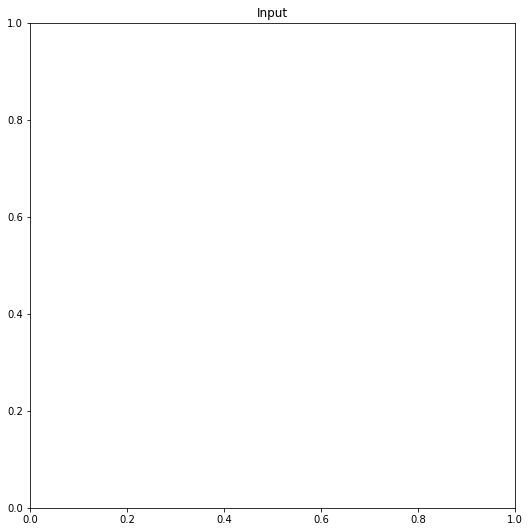

In [30]:

"""### Loss Function"""

from piqa import ssim
from piqa.utils.functional import gaussian_kernel

def get_outnorm(x: torch.Tensor, out_norm: str = '') -> torch.Tensor:
#     """ Common function to get a loss normalization value. Can
#         normalize by either the batch size ('b'), the number of
#         channels ('c'), the image size ('i') or combinations
#         ('bi', 'bci', etc)
#     """
    # b, c, h, w = x.size()
    img_shape = x.shape

    if not out_norm:
        return 1

    norm = 1
    if 'b' in out_norm:
        # normalize by batch size
        # norm /= b
        norm /= img_shape[0]
    if 'c' in out_norm:
        # normalize by the number of channels
        # norm /= c
        norm /= img_shape[-3]
    if 'i' in out_norm:
        # normalize by image/map size
        # norm /= h*w
        norm /= img_shape[-1] * img_shape[-2]

    return norm


class CharbonnierLoss(nn.Module):
    """Charbonnier Loss (L1)"""

    def __init__(self, eps=1e-6, out_norm: str = 'bci'):
        super(CharbonnierLoss, self).__init__()
        self.eps = eps
        self.out_norm = out_norm

    def forward(self, x, y):
        norm = get_outnorm(x, self.out_norm)
        loss = torch.sum(torch.sqrt((x - y).pow(2) + self.eps ** 2))
        return loss * norm


# class SSIMLoss(SSIM):
#     def forward(self, x, y):
        
#         return 1. - super().forward(x, y)
    
if not os.path.exists(res_path):
    os.makedirs(res_path)

scaler = torch.cuda.amp.GradScaler()
optimizer = optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False)

# criterion = nn.L1Loss()


# criterion = SSIMLoss().cuda() 
criterion = CharbonnierLoss()
# num_epochs = epochs
num_epochs = 3
kernel = gaussian_kernel(1).repeat(7,1,1)

# model.to(device)
"""### Training"""
for epoch in range(num_epochs):
    psnr_train = []
    ssim_train = []
    lpips = []
    train_loss = 0
    ssim_best = 0
    count = 0
    psnr_test = []
    ssim_test = []
    lpips_test = []
    model.train()
    st = time.time()
    for batch_num, data in enumerate(train_loader, 0):
        input, target = data[0].to(device), data[1]
        output = model(input.cuda())
        loss = criterion(output, target.cuda())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.item()
        if batch_num % 5 ==0:
            print(f'batch_num {batch_num}')
            psnr_train.append(piq.psnr(output.cpu(), target, reduction='mean').mean())
            ssim_train.append(ssim.ssim(output.cpu(), target, kernel)[0].mean())
        # lpips.append(piq.LPIPS(reduction='mean')(torch.clamp(output, 0, 1), torch.clamp(target.cuda(), 0, 255)))
        torch.cuda.empty_cache()
        gc.collect()
    train_loss /= len(train_loader.dataset)
    psnr_avg= sum(psnr_train)/len(psnr_train)
    ssim_avg= sum(ssim_train)/len(ssim_train)
    # lpips_avg= sum(lpips)/len(train_loader.dataset)
    psnr_max = max(psnr_train)
    ssim_max = max(ssim_train)
    
    if ssim_avg > ssim_best:
        ssim_best = ssim_avg
        params = f'{epoch} , scale={scale} ,ssim = {ssim_best} ,{name}'
        PATH = f'{res_path}/{params}.pth'
        torch.save(model.state_dict(), PATH)
    
    print("Epoch:{} Training Loss:{:.2f} Validation Loss:{:.2f} in {:.2f} and SSIM\n".format(
        epoch + 1, train_loss, val_loss, time.time() - st))
    print(
        f'Train PSNR avg {psnr_avg}, PSNR max {psnr_max} and Train SSIM avg {ssim_avg} , SSIM max {ssim_max}')

        
    # lpips_max = max(lpips)
    

In [34]:
ssim_train, psnr_train

([tensor(0.7407, grad_fn=<MeanBackward0>),
  tensor(0.7520, grad_fn=<MeanBackward0>),
  tensor(0.7571, grad_fn=<MeanBackward0>),
  tensor(0.7649, grad_fn=<MeanBackward0>),
  tensor(0.7830, grad_fn=<MeanBackward0>),
  tensor(0.7628, grad_fn=<MeanBackward0>),
  tensor(0.7643, grad_fn=<MeanBackward0>),
  tensor(0.7783, grad_fn=<MeanBackward0>),
  tensor(0.7642, grad_fn=<MeanBackward0>)],
 [tensor(11.9202, grad_fn=<MeanBackward0>),
  tensor(12.2542, grad_fn=<MeanBackward0>),
  tensor(12.0745, grad_fn=<MeanBackward0>),
  tensor(12.7014, grad_fn=<MeanBackward0>),
  tensor(12.9677, grad_fn=<MeanBackward0>),
  tensor(12.7202, grad_fn=<MeanBackward0>),
  tensor(13.0047, grad_fn=<MeanBackward0>),
  tensor(13.4552, grad_fn=<MeanBackward0>),
  tensor(13.3092, grad_fn=<MeanBackward0>)])

ValueError: Kernel size can't be greater than actual input size. Input size: torch.Size([128, 7, 3, 448, 256]). Kernel size: torch.Size([7, 1, 11, 11])

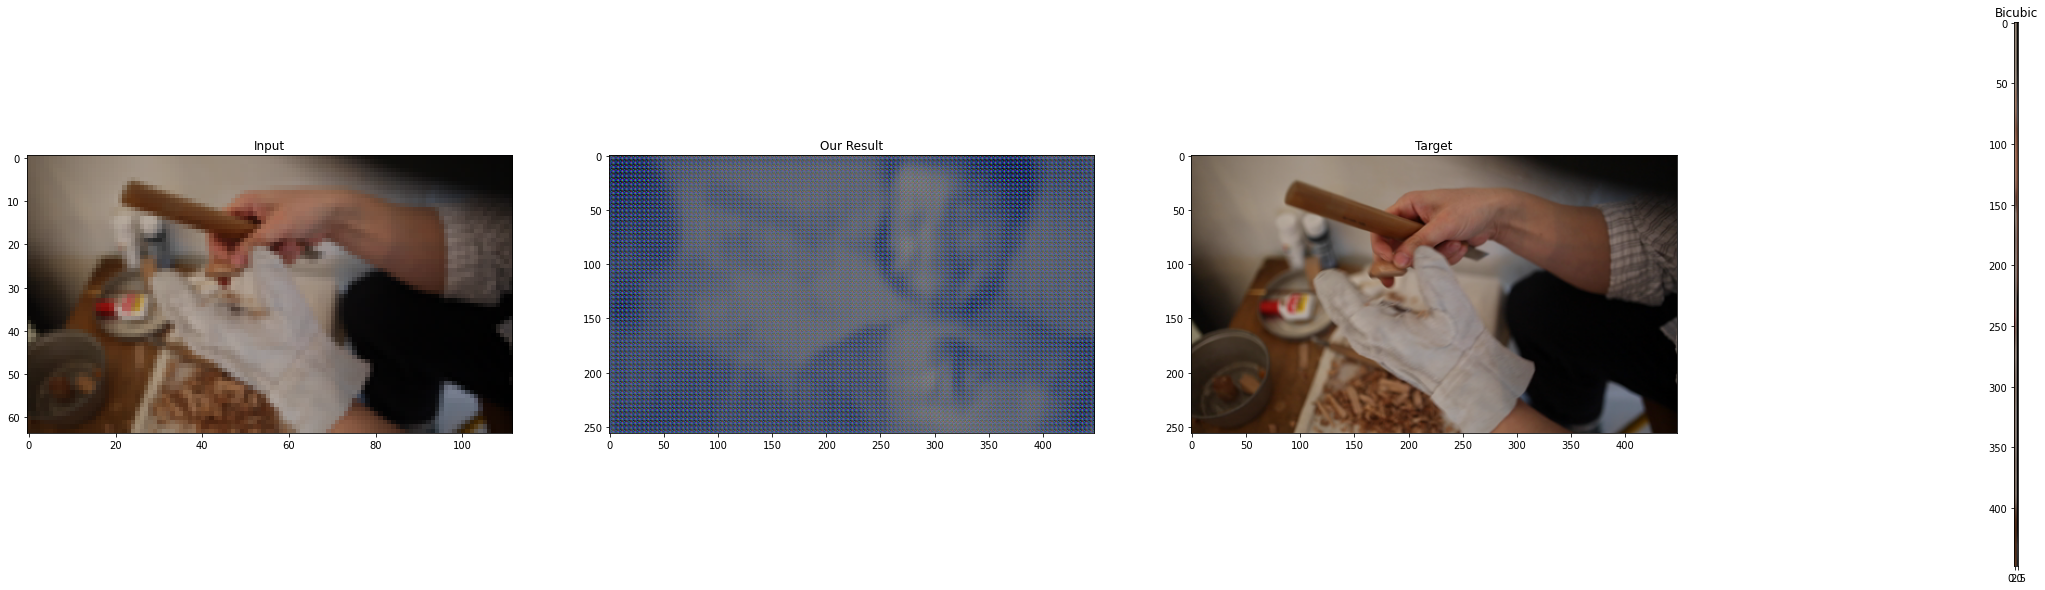

In [31]:
val_loss = 0
model.eval()
with torch.no_grad():
    for input, target in val_loader:
        count+=1
        output = model(input.cuda())
        loss = criterion(output, target.cuda())
        psnr_test.append(piq.psnr(output.cpu(), target, reduction='mean').mean())
        ssim_test.append(ssim.ssim(output.cpu(), target, kernel)[0].mean())
        # lpips_test.append(piq.LPIPS(reduction='mean')(torch.clamp(output, 0, 1), torch.clamp(target.cuda(), 0, 255)))
        val_loss += loss.item()

        if count % 5 == 0 and ssim_avg == ssim_best:
            if not os.path.exists(f'{res_path}/{params}'):
                os.makedirs(f'{res_path}/{params}')
            plt.figure(figsize=(40, 10))
            plt.subplot(141)
            plt.title('Input')
            plt.imshow((input*255.0).cpu()[-1][-1].detach().numpy().T.astype(int))
            plt.subplot(142)
            plt.title('Our Result')
            plt.imshow((output*255.0).cpu()[-1][-1].detach().numpy().T.astype(int))
            plt.subplot(143)
            plt.title('Target')
            plt.imshow((target*255.0).cpu()[-1][-1].detach().numpy().T.astype(int))
            plt.subplot(144)
            plt.title('Bicubic')
            plt.imshow(cv2.resize((input*255.0).cpu()[-1][-1].detach().numpy().T, (target.shape[2],target.shape[3]), interpolation= cv2.INTER_LINEAR).astype(int))
            plt.savefig(f"{res_path}/{params}/psnr_{piq.psnr(output.cpu(), target,  reduction='mean')} "
                        f"and ssim_{piq.ssim(output.cpu(), target)}.png", bbox_inches="tight",
                        pad_inches=0.0)


val_loss /= len(val_loader.dataset)
psnr_test_avg = sum(psnr_test)/len(psnr_test)
ssim_test_avg = sum(ssim_test)/len(ssim_test)
# lpips_test_avg = sum(lpips_test)/len(val_loader.dataset)
psnr_test_max = max(psnr_test)
ssim_test_max = max(ssim_test)
# lpips_test_max = max(lpips_test)

print("Epoch:{} Training Loss:{:.2f} Validation Loss:{:.2f} in {:.2f} and SSIM\n".format(
    epoch+1, train_loss, val_loss, time.time()-st))
print(f'Train PSNR avg {psnr_avg}, PSNR max {psnr_max} and Test PSNR avg {psnr_test_avg}, test PSNR max {psnr_test_max}')
print(f'Train SSIM avg {ssim_avg} , SSIM max {ssim_max} and Test SSIM avg {ssim_test_avg}, test SSIM max {ssim_test_max}')


In [52]:
kernel = gaussian_kernel(3).repeat(7, 1, 1)
kernel.shape

torch.Size([3, 1, 7])

In [68]:
from piqa import ssim
from piqa.utils.functional import gaussian_kernel
x = torch.rand(7, 5, 3, 256, 256)

y = torch.rand(7, 5, 3, 256, 256)

kernel = gaussian_kernel(3).repeat(7, 1, 1)

weights = torch.rand(7)

l = ssim.ssim(x, y, kernel, channel_avg =True)

l[0].mean()

tensor(0.0060)

In [4]:
from piqa import ssim
from piqa.utils.functional import gaussian_kernel

kernel = gaussian_kernel(3).repeat(7, 1, 1)
l = ssim.ssim(torch.ones(128,7,3, 112, 64), torch.ones(128,7,3, 112, 64), kernel)

l[0].mean()

tensor(1.)

In [ ]:
kernel = gaussian_kernel(3).repeat(7, 1, 1)
l = ssim.ssim(output.cpu(), target, kernel)

l[0].mean()

In [76]:
kernel = gaussian_kernel(1).repeat(7,1,1)
l = ssim.ssim(output.cpu(), target, kernel)

l[0].mean()

tensor(0.7921, grad_fn=<MeanBackward0>)

In [116]:
import gc
torch.cuda.empty_cache()
gc.collect()

7092

In [117]:
num_channels=3
num_kernels=64
kernel_size=(3, 3)
padding=(1,1)
activation="relu"
scale=4
group_of_frames = 7
frame_size=(112,64)
convlstm = ConvLSTM(
            in_channels=num_channels, out_channels=num_kernels,
            kernel_size=kernel_size, padding=padding,
            activation=activation, frame_size=frame_size)

In [118]:
class Seq2Seq(nn.Module):

    def __init__(self, num_channels, num_kernels, kernel_size, padding, 
    activation, frame_size, num_layers):

        super(Seq2Seq, self).__init__()

        self.sequential = nn.Sequential()

        # Add First layer (Different in_channels than the rest)
        self.sequential.add_module(
            "convlstm1", ConvLSTM(
                in_channels=num_channels, out_channels=num_kernels,
                kernel_size=kernel_size, padding=padding, 
                activation=activation, frame_size=frame_size)
        )

        self.sequential.add_module(
            "batchnorm1", nn.BatchNorm3d(num_features=num_kernels)
        ) 

        # Add rest of the layers
        for l in range(2, num_layers+1):

            self.sequential.add_module(
                f"convlstm{l}", ConvLSTM(
                    in_channels=num_kernels, out_channels=num_kernels,
                    kernel_size=kernel_size, padding=padding, 
                    activation=activation, frame_size=frame_size)
                )
                
            self.sequential.add_module(
                f"batchnorm{l}", nn.BatchNorm3d(num_features=num_kernels)
                ) 

        # Add Convolutional Layer to predict output frame
        self.conv = nn.Conv2d(
            in_channels=num_kernels, out_channels=num_channels,
            kernel_size=kernel_size, padding=padding)

    def forward(self, X):

        # Forward propagation through all the layers
        output = self.sequential(X)

        # Return only the last output frame
        output = self.conv(output[:,:,-1])
        
        return nn.Sigmoid()(output)

In [119]:
sequential = Seq2Seq(num_channels=3, num_kernels=64, 
kernel_size=(3, 3), padding=(1, 1), activation="relu", 
frame_size=(112, 64), num_layers=3).to(device)

In [120]:
train_loader.dataset[0][0].shape

torch.Size([7, 3, 112, 64])

In [95]:
# device = torch.device('cpu')
import gc
input = torch.ones(128, 3,7, 112, 64)
input = input.to(device)
output = sequential(input)

torch.cuda.empty_cache()
gc.collect()
output.size(), output.mean()

(torch.Size([128, 3, 112, 64]),
 tensor(0.4864, device='cuda:0', grad_fn=<MeanBackward0>))

In [96]:
device = torch.device('cpu')
import gc
input = torch.ones(128, 3,7, 112, 64)*255.0
input = input.to(device)
output = convlstm(input)

torch.cuda.empty_cache()
gc.collect()
output.size(), output.mean(),output[:,:,-1].size(),output[:,:,0].mean()

(torch.Size([128, 64, 7, 112, 64]),
 tensor(25.7077, grad_fn=<MeanBackward0>),
 torch.Size([128, 64, 112, 64]),
 tensor(6.1006, grad_fn=<MeanBackward0>))

In [122]:
model

mdpvsr_1defconv(
  (sequential): Sequential(
    (convlstm1): ConvLSTM(
      (convLSTMcell): ConvLSTMCell(
        (conv): Conv2d(67, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (batchnorm1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (convlstm2): ConvLSTM(
      (convLSTMcell): ConvLSTMCell(
        (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (batchnorm2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (convlstm3): ConvLSTM(
      (convLSTMcell): ConvLSTMCell(
        (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (batchnorm3): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deformable_convolution1): DeformableConv2d(
    (offset_conv): Conv2d(21, 18, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (modulator_conv): Conv2d(21, 9, kernel_

In [121]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import gc
input = torch.ones(2, 7, 3, 112, 64)
input = input.to(device)
output = model(input)

torch.cuda.empty_cache()
gc.collect()
output.size(), output.mean()

Input torch.Size([2, 3, 7, 112, 64])
output from convlstm torch.Size([2, 64, 7, 112, 64])
output from conv1 torch.Size([2, 3, 7, 112, 64])
input to def conv shape torch.Size([2, 21, 112, 64])


(torch.Size([2, 7, 3, 448, 256]),
 tensor(0.4850, device='cuda:0', grad_fn=<MeanBackward0>))

In [78]:

# model.eval()
# ssim_val = []
# psnr_val = []
# lpips_val = []
# running_psnr = 0

# with torch.no_grad():
#     for input, target in test_loader:
#         output = model(input.cuda())
#         psnr_val.append(piq.psnr(output.cpu(), target, data_range=255., reduction='mean'))
#         ssim_val.append(piq.ssim(output.cpu(), target, data_range=255.))
#         lpips_val.append(piq.LPIPS(reduction='mean')(torch.clamp(output, 0, 1), torch.clamp(target.cuda(), 0, 255)))

#         print(f'psnr value ={psnr_val[-1]}')
#         print(f'ssim value ={ssim_val[-1]}')
#         print(f'lpips value ={lpips_val[-1]}')

#     with open(r'name_quality metrics', 'w') as fp:
#         fp.write("\n PSNR")
#         for item in psnr_val:
#             # write each item on a new line
#             fp.write("%s\n" % item)

#         fp.write("\n SSIM")
#         for item in ssim_val:
#             # write each item on a new line
#             fp.write("%s\n" % item)

#         fp.write("\n LPIPS")
#         for item in lpips_val:
#             # write each item on a new line
#             fp.write("%s\n" % item)

